**Classifying Brain MRI images using Transfer Learning and Data Augmentation**

Rafael Espinosa Mena

Rafaelespinosamena@gmail.com



In [1]:
# Install the splitfolders package
!pip install split-folders

In [12]:
import sys
!{sys.executable} -m pip install split-folders
import splitfolders
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from numpy.random import seed
from google.colab import drive
import os
import splitfolders
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.metrics import classification_report

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Set the path to the dataset in Google Drive
path = "/content/drive/My Drive/Brain MRI Project/MRIData"

# Check if the path is correct and list files
print("Folders in the dataset:", os.listdir(path))

# Split the data into train, validation, and test sets
splitfolders.ratio(path, seed=331, output="/content/drive/My Drive/Brain MRI Project/data-Splitted", ratio=(0.6, 0.2, 0.2))

# Set the directory paths for train and validation
train_dir = "/content/drive/My Drive/Brain MRI Project/data-Splitted/train"
valid_dir = "/content/drive/My Drive/Brain MRI Project/data-Splitted/val"
test_dir = "/content/drive/My Drive/Brain MRI Project/data-Splitted/test"

# Define input size
input_size = 299

# Create Image Data Generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.05,
                                   zoom_range=0.1,
                                   brightness_range=[0.7,1.2],
                                   horizontal_flip=True,
                                   fill_mode='constant', cval=0)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(input_size, input_size),
                                                    class_mode='binary',
                                                    batch_size=4)

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(input_size, input_size),
                                                    class_mode='binary',
                                                    batch_size=4)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(input_size, input_size),
    class_mode='binary',
    batch_size=1,
    shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folders in the dataset: ['no', 'yes']


Copying files: 253 files [00:03, 67.06 files/s]

Found 151 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Found 52 images belonging to 2 classes.


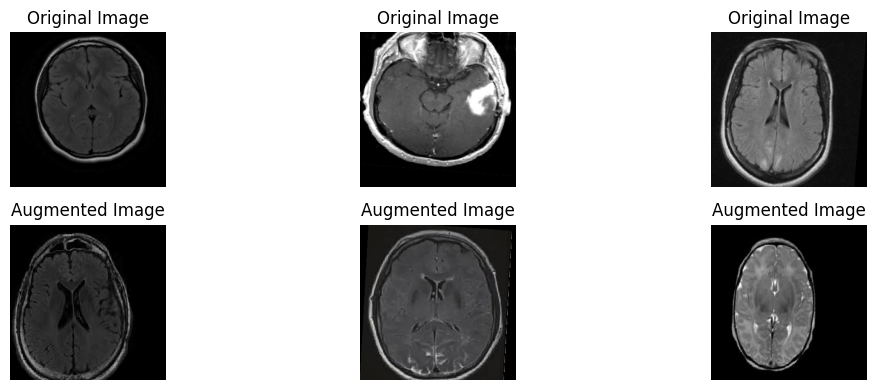

In [4]:
# Function to display original and augmented images
def display_original_and_augmented_images(generator, num_samples=3):
    plt.figure(figsize=(12, 4))

    for i in range(num_samples):
        # Fetch a batch of images (original + augmented)
        images_batch, _ = next(generator)

        # Display original image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images_batch[0])
        plt.title('Original Image')
        plt.axis('off')

        # Display augmented image
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(images_batch[1])
        plt.title('Augmented Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display the images using the train generator
display_original_and_augmented_images(train_generator, num_samples=3)


In [5]:
Counter(train_generator.classes)

Counter({0: 58, 1: 93})

In [6]:
# Define the model architecture (example using InceptionResNetV2)
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(input_size, input_size, 3))
base_model.trainable = False  # Freeze the base model layers

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(218, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 98304)             0         
                                                                 
 dense (Dense)               (None, 512)               50332160  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 218)               111834    
                                                                 
 dropout_1 (Dropout)         (None, 218)               0         
                                                        

In [7]:
# Compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
model_save_path = '/content/drive/My Drive/Brain MRI Project/best_model_MRI.hdf5'
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history = model.fit(train_generator,
                    epochs=50,  # Adjust the number of epochs
                    validation_data=valid_generator,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.6556
Epoch 1: val_loss improved from inf to 0.33073, saving model to /content/drive/My Drive/Brain MRI Project/best_model_MRI.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 58s 646ms/step - loss: 0.7427 - accuracy: 0.6556 - val_loss: 0.3307 - val_accuracy: 0.9200
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.7152
Epoch 2: val_loss improved from 0.33073 to 0.26145, saving model to /content/drive/My Drive/Brain MRI Project/best_model_MRI.hdf5
38/38 [==============================] - 13s 359ms/step - loss: 0.5753 - accuracy: 0.7152 - val_loss: 0.2614 - val_accuracy: 0.9200
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.7483
Epoch 3: val_loss improved from 0.26145 to 0.24126, saving model to /content/drive/My Drive/Brain MRI Project/best_model_MRI.hdf5
38/38 [==============================] - 12s 312ms/step - loss: 0.4800 - accuracy: 0.7483 - val_loss: 0.2413 - val_accuracy: 0.9000
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8344
Epoch 4: val_loss did not improve from 0.24126
38/38 [========

In [8]:
# Evaluate the model on the test set
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict(test_generator, steps=nb_samples)

# Post-processing for evaluation (optional)
predictions = [1 if x > 0.5 else 0 for x in predict]
true_labels = test_generator.classes

52/52 [==============================] - 7s 34ms/step


In [9]:
print("Accuracy Score:", accuracy_score(true_labels, predictions))

Accuracy Score: 0.9423076923076923


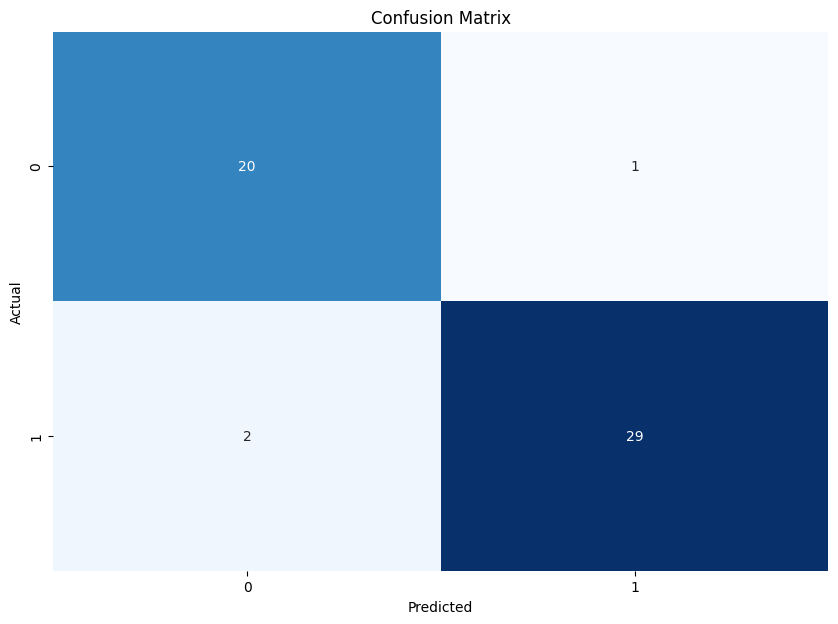

In [10]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

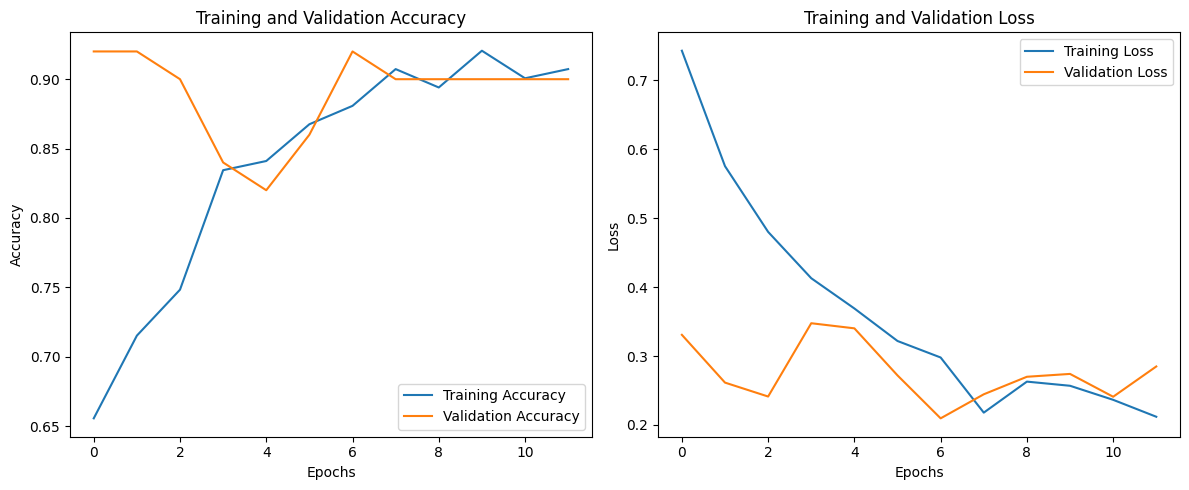

In [11]:
# Extract training and validation accuracies and losses from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Number of epochs

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Generate predictions
predict = model.predict(test_generator, steps=nb_samples)
predictions = [1 if x > 0.5 else 0 for x in predict]

# True labels
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys())

print(report)

52/52 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

          no       0.91      0.95      0.93        21
         yes       0.97      0.94      0.95        31

    accuracy                           0.94        52
   macro avg       0.94      0.94      0.94        52
weighted avg       0.94      0.94      0.94        52

